# Step 2: Build And Evaluate Classifiers /Step 3: Classify All The Users

### load labeled data

In [94]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
labeledData = pd.read_csv('labeledData_cleaned.csv', encoding = "ISO-8859-1")

In [3]:
labeledData.head(10)

,creator_name,userid,comment,labels
0,Lil Bub,1107261,Love you Lil Bub. Coos purrss and kisses to yo...,2.0
1,Funny Pets,683992,This is my cat he jumps on me then climbs unti...,2.0
2,stacyvlogs,377676,Feral cats are hard to tame since they do not ...,0.0
3,Cole & Marmalade,287156,If thats true then my cat sees a lot of ghosts,2.0
4,Robin Seplut,2356137,its like my died cat MARCO. hiks,2.0
5,Frozen Kitten,847347,omg I feel like thats my cat my cat had orange...,2.0
6,Dogumentary TV,1567221,Had a male and female stubborn on food they wi...,0.0
7,TheMeanKitty,942869,Oh no I watched this on the TV and now my cat ...,2.0
8,Funny Pets,2158606,the first cat looks like my dead cat __,2.0
9,Taylor Nicole Dean,1567092,Can you name the grey one Button after my dead...,2.0


In [4]:
# drop nan
labeledData = labeledData.dropna()

In [5]:
# reset index
labeledData = labeledData.reset_index(drop=True)

In [6]:
labeledData.shape

(96474, 4)

### load all data

In [65]:
data = pd.read_csv('animals_comments.csv')

In [66]:
# drop duplicated data
data = data.drop_duplicates()

In [67]:
# drop nan
data = data.dropna()

In [68]:
# reset index
data = data.reset_index(drop=True)

### Represent text as numerical data

In [70]:
# instantiate CountVectorizer (vectorizer)
vect1 = CountVectorizer()

In [72]:
# fit
# learn the 'vocabulary' of the training data (occurs in-place)
vect1.fit(data['comment'].astype('U'))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [73]:
# examine the fitted vocabulary
vocabulary = vect1.get_feature_names()
len(vocabulary)

1224579

In [74]:
# transform training data
train = vect1.transform(labeledData['comment'].astype('U'))
train

<96474x1224579 sparse matrix of type '<class 'numpy.int64'>'
	with 1114340 stored elements in Compressed Sparse Row format>

In [77]:
# transform all data
transData = vect1.transform(data['comment'].astype('U'))
transData

<5725601x1224579 sparse matrix of type '<class 'numpy.int64'>'
	with 68710776 stored elements in Compressed Sparse Row format>

## Train model by XGBoost

In [78]:
import xgboost as xgb
import gc
from scipy.sparse import csr_matrix
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
import os  # for Macbook
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### 5-fold cross validation splits

In [79]:
split = 5
skf = StratifiedKFold(n_splits = split)
skf.get_n_splits(train, target)

5

In [80]:
num_boost_round = 500
params = {}
params["objective"] = 'multi:softprob'
params["eta"] = 0.03 # learning rate
params["subsample"] = 1  # 随机采样训练样本 训练实例的子采样比
params["colsample_bytree"] = 0.7 # 生成树时进行的列采样
params["silent"] = 0 #设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
params["max_depth"] = 5 # 构建树的深度，越大越容易过拟合
params["min_child_weight"] = 1
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
params["eval_metric"] = "mlogloss"
params["num_class"] = 3

In [81]:
train_preds = None
test_preds = None
xgb_classifiers = [] # List[[clf, score]]
index = 0
for train_index, test_index in skf.split(train, target):
    print('Fold:', index + 1)
    index = index + 1
    X_train, X_test = train[train_index], train[test_index] # split training set into'train', 'cross-validation' sets
    y_train, y_test = target[train_index], target[test_index]
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    # for xgb classifier, we transform them into DMatrix format
    D_train = xgb.DMatrix(
                    csr_matrix(X_train),
                    y_train,
                    silent = True)
#    print(D_train.num_col())
#    print(D_train.num_row())
    
    D_test = xgb.DMatrix(
                    csr_matrix(X_test),
                    y_test,
                    silent = True)
#    watchlist = [(D_test, 'test'), (D_train, 'train')]
    watchlist = [(D_train, 'train'), (D_test, 'test')]
#    print(D_test.num_col())
#    print(D_test.num_row())
  
    # fit the classfier now
    clf = xgb.train(params, D_train, num_boost_round,
                    evals = watchlist, early_stopping_rounds = 10)
    
    test_prediction = clf.predict(D_test)
    print('Blind Log Loss:', log_loss(y_test, test_prediction))
    score = accuracy_score(y_test, test_prediction.argmax(axis=1))
    print('Accuracy score:', score)
    
    
    del X_train, X_test, D_train, D_test
    gc.collect()
    print('finished a training model')
    print('fitting on full data set now...')
    
    D_full_train = \
        xgb.DMatrix(csr_matrix(train),
                    target,
                    silent = True)
    D_full_test = \
        xgb.DMatrix(csr_matrix(transData),
                    silent = True)
    if(train_preds is None):
        train_preds = clf.predict(D_full_train).argmax(axis=1)
        test_preds = clf.predict(D_full_test)
    else:
        train_preds *= clf.predict(D_full_train).argmax(axis=1) # we manually perform an average of the results
        test_preds *= clf.predict(D_full_test)
    xgb_classifiers.append([clf, 'with accuracy score: {:10f}'.format(score)])
    del D_full_train, clf
    gc.collect()


print('Done!')

Fold: 1
(77178, 1224579)
(19296, 1224579)
(77178,)
(19296,)


/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-mlogloss:1.05514	test-mlogloss:1.05525
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.01413	test-mlogloss:1.01421
[2]	train-mlogloss:0.974984	test-mlogloss:0.975031
[3]	train-mlogloss:0.937927	test-mlogloss:0.938072
[4]	train-mlogloss:0.902686	test-mlogloss:0.902952
[5]	train-mlogloss:0.869527	test-mlogloss:0.869838
[6]	train-mlogloss:0.837605	test-mlogloss:0.838094
[7]	train-mlogloss:0.807345	test-mlogloss:0.807801
[8]	train-mlogloss:0.778469	test-mlogloss:0.778955
[9]	train-mlogloss:0.750837	test-mlogloss:0.751468
[10]	train-mlogloss:0.724486	test-mlogloss:0.725132
[11]	train-mlogloss:0.699247	test-mlogloss:0.700021
[12]	train-mlogloss:0.675263	test-mlogloss:0.676031
[13]	train-mlogloss:0.652111	test-mlogloss:0.652886
[14]	train-mlogloss:0.629798	test-mlogloss:0.630619
[15]	train-mlogloss:0.608606	test-mlogloss:0.609532
[16]	train-mlogloss:0.588126	te

[155]	train-mlogloss:0.020076	test-mlogloss:0.02516
[156]	train-mlogloss:0.019808	test-mlogloss:0.024922
[157]	train-mlogloss:0.019533	test-mlogloss:0.024674
[158]	train-mlogloss:0.019294	test-mlogloss:0.024457
[159]	train-mlogloss:0.019031	test-mlogloss:0.024215
[160]	train-mlogloss:0.018815	test-mlogloss:0.024011
[161]	train-mlogloss:0.01856	test-mlogloss:0.023772
[162]	train-mlogloss:0.018317	test-mlogloss:0.023552
[163]	train-mlogloss:0.018099	test-mlogloss:0.023356
[164]	train-mlogloss:0.017885	test-mlogloss:0.023164
[165]	train-mlogloss:0.017632	test-mlogloss:0.022933
[166]	train-mlogloss:0.017424	test-mlogloss:0.022741
[167]	train-mlogloss:0.017183	test-mlogloss:0.022517
[168]	train-mlogloss:0.016964	test-mlogloss:0.022315
[169]	train-mlogloss:0.016781	test-mlogloss:0.022157
[170]	train-mlogloss:0.016626	test-mlogloss:0.022017
[171]	train-mlogloss:0.016454	test-mlogloss:0.021871
[172]	train-mlogloss:0.016264	test-mlogloss:0.021712
[173]	train-mlogloss:0.016094	test-mlogloss:0.02

[311]	train-mlogloss:0.00843	test-mlogloss:0.016022
[312]	train-mlogloss:0.008413	test-mlogloss:0.016016
[313]	train-mlogloss:0.008405	test-mlogloss:0.016012
[314]	train-mlogloss:0.008391	test-mlogloss:0.016006
[315]	train-mlogloss:0.008377	test-mlogloss:0.016007
[316]	train-mlogloss:0.008361	test-mlogloss:0.016008
[317]	train-mlogloss:0.008344	test-mlogloss:0.016005
[318]	train-mlogloss:0.008336	test-mlogloss:0.016004
[319]	train-mlogloss:0.008322	test-mlogloss:0.016
[320]	train-mlogloss:0.008302	test-mlogloss:0.01599
[321]	train-mlogloss:0.008295	test-mlogloss:0.015992
[322]	train-mlogloss:0.00828	test-mlogloss:0.015984
[323]	train-mlogloss:0.008268	test-mlogloss:0.015978
[324]	train-mlogloss:0.008254	test-mlogloss:0.015975
[325]	train-mlogloss:0.008245	test-mlogloss:0.01597
[326]	train-mlogloss:0.008232	test-mlogloss:0.015972
[327]	train-mlogloss:0.008223	test-mlogloss:0.015969
[328]	train-mlogloss:0.008212	test-mlogloss:0.015969
[329]	train-mlogloss:0.008201	test-mlogloss:0.015976


/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Fold: 2
(77179, 1224579)
(19295, 1224579)
(77179,)
(19295,)
[0]	train-mlogloss:1.05512	test-mlogloss:1.05527
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.01412	test-mlogloss:1.01423
[2]	train-mlogloss:0.974944	test-mlogloss:0.975051
[3]	train-mlogloss:0.937873	test-mlogloss:0.938112
[4]	train-mlogloss:0.902634	test-mlogloss:0.903007
[5]	train-mlogloss:0.869491	test-mlogloss:0.869857
[6]	train-mlogloss:0.83756	test-mlogloss:0.838153
[7]	train-mlogloss:0.807304	test-mlogloss:0.807856
[8]	train-mlogloss:0.778416	test-mlogloss:0.779005
[9]	train-mlogloss:0.750798	test-mlogloss:0.75152
[10]	train-mlogloss:0.724442	test-mlogloss:0.725198
[11]	train-mlogloss:0.699191	test-mlogloss:0.700072
[12]	train-mlogloss:0.675205	test-mlogloss:0.676135
[13]	train-mlogloss:0.652063	test-mlogloss:0.653001
[14]	train-mlogloss:0.629738	test-mlogloss:0.630722
[15]	train-mlogloss:0.608

[154]	train-mlogloss:0.020188	test-mlogloss:0.025783
[155]	train-mlogloss:0.019885	test-mlogloss:0.025498
[156]	train-mlogloss:0.019619	test-mlogloss:0.025242
[157]	train-mlogloss:0.019342	test-mlogloss:0.024993
[158]	train-mlogloss:0.019103	test-mlogloss:0.024773
[159]	train-mlogloss:0.018841	test-mlogloss:0.024538
[160]	train-mlogloss:0.018624	test-mlogloss:0.024346
[161]	train-mlogloss:0.018371	test-mlogloss:0.024115
[162]	train-mlogloss:0.018127	test-mlogloss:0.023894
[163]	train-mlogloss:0.017905	test-mlogloss:0.023687
[164]	train-mlogloss:0.017688	test-mlogloss:0.023487
[165]	train-mlogloss:0.017438	test-mlogloss:0.023256
[166]	train-mlogloss:0.017229	test-mlogloss:0.023062
[167]	train-mlogloss:0.016991	test-mlogloss:0.022844
[168]	train-mlogloss:0.016776	test-mlogloss:0.02265
[169]	train-mlogloss:0.016593	test-mlogloss:0.022488
[170]	train-mlogloss:0.016433	test-mlogloss:0.022355
[171]	train-mlogloss:0.016262	test-mlogloss:0.022203
[172]	train-mlogloss:0.016077	test-mlogloss:0.0

[310]	train-mlogloss:0.008198	test-mlogloss:0.016283
[311]	train-mlogloss:0.008183	test-mlogloss:0.01628
[312]	train-mlogloss:0.008167	test-mlogloss:0.01627
[313]	train-mlogloss:0.008157	test-mlogloss:0.016273
[314]	train-mlogloss:0.008147	test-mlogloss:0.016268
[315]	train-mlogloss:0.008134	test-mlogloss:0.016263
[316]	train-mlogloss:0.008118	test-mlogloss:0.016262
[317]	train-mlogloss:0.008101	test-mlogloss:0.016255
[318]	train-mlogloss:0.008094	test-mlogloss:0.016256
[319]	train-mlogloss:0.008077	test-mlogloss:0.016246
[320]	train-mlogloss:0.008061	test-mlogloss:0.016237
[321]	train-mlogloss:0.008053	test-mlogloss:0.016236
[322]	train-mlogloss:0.008039	test-mlogloss:0.016226
[323]	train-mlogloss:0.008026	test-mlogloss:0.016221
[324]	train-mlogloss:0.008013	test-mlogloss:0.016218
[325]	train-mlogloss:0.008002	test-mlogloss:0.016215
[326]	train-mlogloss:0.007991	test-mlogloss:0.016211
[327]	train-mlogloss:0.007982	test-mlogloss:0.016215
[328]	train-mlogloss:0.00797	test-mlogloss:0.016

/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


finished a training model
fitting on full data set now...
Fold: 3
(77179, 1224579)
(19295, 1224579)
(77179,)
(19295,)
[0]	train-mlogloss:1.05513	test-mlogloss:1.05528
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.01411	test-mlogloss:1.01423
[2]	train-mlogloss:0.974948	test-mlogloss:0.975049
[3]	train-mlogloss:0.937863	test-mlogloss:0.938081
[4]	train-mlogloss:0.902646	test-mlogloss:0.902968
[5]	train-mlogloss:0.869494	test-mlogloss:0.869839
[6]	train-mlogloss:0.837553	test-mlogloss:0.838072
[7]	train-mlogloss:0.807293	test-mlogloss:0.807773
[8]	train-mlogloss:0.778417	test-mlogloss:0.778907
[9]	train-mlogloss:0.750798	test-mlogloss:0.751418
[10]	train-mlogloss:0.724437	test-mlogloss:0.725087
[11]	train-mlogloss:0.699195	test-mlogloss:0.699975
[12]	train-mlogloss:0.675207	test-mlogloss:0.676
[13]	train-mlogloss:0.652063	test-mlogloss:0.652865
[14]	train-mlogloss:

[153]	train-mlogloss:0.020569	test-mlogloss:0.025685
[154]	train-mlogloss:0.020279	test-mlogloss:0.025428
[155]	train-mlogloss:0.019974	test-mlogloss:0.025149
[156]	train-mlogloss:0.019712	test-mlogloss:0.024905
[157]	train-mlogloss:0.019436	test-mlogloss:0.024659
[158]	train-mlogloss:0.019198	test-mlogloss:0.024429
[159]	train-mlogloss:0.01894	test-mlogloss:0.024188
[160]	train-mlogloss:0.018723	test-mlogloss:0.023995
[161]	train-mlogloss:0.01847	test-mlogloss:0.023757
[162]	train-mlogloss:0.018228	test-mlogloss:0.023533
[163]	train-mlogloss:0.018011	test-mlogloss:0.023329
[164]	train-mlogloss:0.017797	test-mlogloss:0.023129
[165]	train-mlogloss:0.017547	test-mlogloss:0.022891
[166]	train-mlogloss:0.01734	test-mlogloss:0.022698
[167]	train-mlogloss:0.017099	test-mlogloss:0.022475
[168]	train-mlogloss:0.016878	test-mlogloss:0.022265
[169]	train-mlogloss:0.016699	test-mlogloss:0.022105
[170]	train-mlogloss:0.016543	test-mlogloss:0.021971
[171]	train-mlogloss:0.016375	test-mlogloss:0.021

[309]	train-mlogloss:0.008311	test-mlogloss:0.015975
[310]	train-mlogloss:0.008296	test-mlogloss:0.015969
[311]	train-mlogloss:0.008277	test-mlogloss:0.015959
[312]	train-mlogloss:0.008261	test-mlogloss:0.015945
[313]	train-mlogloss:0.008251	test-mlogloss:0.015945
[314]	train-mlogloss:0.008239	test-mlogloss:0.015942
[315]	train-mlogloss:0.008223	test-mlogloss:0.015937
[316]	train-mlogloss:0.008206	test-mlogloss:0.01594
[317]	train-mlogloss:0.008189	test-mlogloss:0.015934
[318]	train-mlogloss:0.008178	test-mlogloss:0.015938
[319]	train-mlogloss:0.008163	test-mlogloss:0.015938
[320]	train-mlogloss:0.008143	test-mlogloss:0.015938
[321]	train-mlogloss:0.008135	test-mlogloss:0.015937
[322]	train-mlogloss:0.008119	test-mlogloss:0.015926
[323]	train-mlogloss:0.008107	test-mlogloss:0.015926
[324]	train-mlogloss:0.008092	test-mlogloss:0.015924
[325]	train-mlogloss:0.008082	test-mlogloss:0.015927
[326]	train-mlogloss:0.008066	test-mlogloss:0.015922
[327]	train-mlogloss:0.008054	test-mlogloss:0.0

/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Fold: 4
(77180, 1224579)
(19294, 1224579)
(77180,)
(19294,)
[0]	train-mlogloss:1.05513	test-mlogloss:1.05524
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.01412	test-mlogloss:1.01419
[2]	train-mlogloss:0.974963	test-mlogloss:0.974996
[3]	train-mlogloss:0.937907	test-mlogloss:0.938025
[4]	train-mlogloss:0.902684	test-mlogloss:0.90293
[5]	train-mlogloss:0.869528	test-mlogloss:0.869731
[6]	train-mlogloss:0.837645	test-mlogloss:0.837927
[7]	train-mlogloss:0.807355	test-mlogloss:0.807656
[8]	train-mlogloss:0.778495	test-mlogloss:0.778797
[9]	train-mlogloss:0.750866	test-mlogloss:0.751253
[10]	train-mlogloss:0.724512	test-mlogloss:0.724926
[11]	train-mlogloss:0.699277	test-mlogloss:0.699817
[12]	train-mlogloss:0.675295	test-mlogloss:0.675795
[13]	train-mlogloss:0.65216	test-mlogloss:0.652641
[14]	train-mlogloss:0.629829	test-mlogloss:0.63036
[15]	train-mlogloss:0.6086

[154]	train-mlogloss:0.020375	test-mlogloss:0.024496
[155]	train-mlogloss:0.020069	test-mlogloss:0.024208
[156]	train-mlogloss:0.019799	test-mlogloss:0.023963
[157]	train-mlogloss:0.019521	test-mlogloss:0.023704
[158]	train-mlogloss:0.019282	test-mlogloss:0.02348
[159]	train-mlogloss:0.019022	test-mlogloss:0.02324
[160]	train-mlogloss:0.018804	test-mlogloss:0.023034
[161]	train-mlogloss:0.018548	test-mlogloss:0.022807
[162]	train-mlogloss:0.018304	test-mlogloss:0.022588
[163]	train-mlogloss:0.018078	test-mlogloss:0.022382
[164]	train-mlogloss:0.01786	test-mlogloss:0.022186
[165]	train-mlogloss:0.017607	test-mlogloss:0.021954
[166]	train-mlogloss:0.017398	test-mlogloss:0.021767
[167]	train-mlogloss:0.017157	test-mlogloss:0.021557
[168]	train-mlogloss:0.01694	test-mlogloss:0.021359
[169]	train-mlogloss:0.016758	test-mlogloss:0.021209
[170]	train-mlogloss:0.016598	test-mlogloss:0.021066
[171]	train-mlogloss:0.016427	test-mlogloss:0.020917
[172]	train-mlogloss:0.016237	test-mlogloss:0.0207

[310]	train-mlogloss:0.008288	test-mlogloss:0.014848
[311]	train-mlogloss:0.008271	test-mlogloss:0.014841
[312]	train-mlogloss:0.00825	test-mlogloss:0.014832
[313]	train-mlogloss:0.008239	test-mlogloss:0.014832
[314]	train-mlogloss:0.008227	test-mlogloss:0.014828
[315]	train-mlogloss:0.008213	test-mlogloss:0.014818
[316]	train-mlogloss:0.008197	test-mlogloss:0.014813
[317]	train-mlogloss:0.008184	test-mlogloss:0.014806
[318]	train-mlogloss:0.008171	test-mlogloss:0.014804
[319]	train-mlogloss:0.008158	test-mlogloss:0.014801
[320]	train-mlogloss:0.008134	test-mlogloss:0.01479
[321]	train-mlogloss:0.008123	test-mlogloss:0.014793
[322]	train-mlogloss:0.008107	test-mlogloss:0.014783
[323]	train-mlogloss:0.008095	test-mlogloss:0.014772
[324]	train-mlogloss:0.00808	test-mlogloss:0.01477
[325]	train-mlogloss:0.008068	test-mlogloss:0.014771
[326]	train-mlogloss:0.008055	test-mlogloss:0.01477
[327]	train-mlogloss:0.008047	test-mlogloss:0.014772
[328]	train-mlogloss:0.008034	test-mlogloss:0.01476

/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Fold: 5
(77180, 1224579)
(19294, 1224579)
(77180,)
(19294,)
[0]	train-mlogloss:1.05513	test-mlogloss:1.05521
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	train-mlogloss:1.01412	test-mlogloss:1.01414
[2]	train-mlogloss:0.974976	test-mlogloss:0.974893
[3]	train-mlogloss:0.937935	test-mlogloss:0.937885
[4]	train-mlogloss:0.902708	test-mlogloss:0.902763
[5]	train-mlogloss:0.869562	test-mlogloss:0.869547
[6]	train-mlogloss:0.837629	test-mlogloss:0.837709
[7]	train-mlogloss:0.807409	test-mlogloss:0.807392
[8]	train-mlogloss:0.778534	test-mlogloss:0.778472
[9]	train-mlogloss:0.750912	test-mlogloss:0.750944
[10]	train-mlogloss:0.724571	test-mlogloss:0.724611
[11]	train-mlogloss:0.69934	test-mlogloss:0.699461
[12]	train-mlogloss:0.67536	test-mlogloss:0.675413
[13]	train-mlogloss:0.652209	test-mlogloss:0.65221
[14]	train-mlogloss:0.6299	test-mlogloss:0.629927
[15]	train-mlogloss:0.608704

[154]	train-mlogloss:0.020537	test-mlogloss:0.02417
[155]	train-mlogloss:0.020231	test-mlogloss:0.023882
[156]	train-mlogloss:0.01996	test-mlogloss:0.023631
[157]	train-mlogloss:0.019683	test-mlogloss:0.023374
[158]	train-mlogloss:0.019446	test-mlogloss:0.023165
[159]	train-mlogloss:0.01918	test-mlogloss:0.022928
[160]	train-mlogloss:0.018962	test-mlogloss:0.022729
[161]	train-mlogloss:0.01871	test-mlogloss:0.022502
[162]	train-mlogloss:0.018463	test-mlogloss:0.022277
[163]	train-mlogloss:0.018241	test-mlogloss:0.02207
[164]	train-mlogloss:0.018022	test-mlogloss:0.021881
[165]	train-mlogloss:0.01777	test-mlogloss:0.021646
[166]	train-mlogloss:0.017556	test-mlogloss:0.021462
[167]	train-mlogloss:0.017315	test-mlogloss:0.021226
[168]	train-mlogloss:0.017095	test-mlogloss:0.021033
[169]	train-mlogloss:0.016911	test-mlogloss:0.020871
[170]	train-mlogloss:0.016749	test-mlogloss:0.020747
[171]	train-mlogloss:0.016585	test-mlogloss:0.020603
[172]	train-mlogloss:0.016398	test-mlogloss:0.020431

[310]	train-mlogloss:0.008467	test-mlogloss:0.014671
[311]	train-mlogloss:0.008453	test-mlogloss:0.01467
[312]	train-mlogloss:0.008438	test-mlogloss:0.014659
[313]	train-mlogloss:0.008427	test-mlogloss:0.014656
[314]	train-mlogloss:0.008414	test-mlogloss:0.014651
[315]	train-mlogloss:0.008401	test-mlogloss:0.014645
[316]	train-mlogloss:0.008385	test-mlogloss:0.014632
[317]	train-mlogloss:0.008369	test-mlogloss:0.014627
[318]	train-mlogloss:0.00836	test-mlogloss:0.014625
[319]	train-mlogloss:0.008347	test-mlogloss:0.014616
[320]	train-mlogloss:0.008327	test-mlogloss:0.014606
[321]	train-mlogloss:0.008317	test-mlogloss:0.014606
[322]	train-mlogloss:0.008302	test-mlogloss:0.014593
[323]	train-mlogloss:0.008289	test-mlogloss:0.014593
[324]	train-mlogloss:0.008276	test-mlogloss:0.014585
[325]	train-mlogloss:0.008267	test-mlogloss:0.014588
[326]	train-mlogloss:0.008252	test-mlogloss:0.014579
[327]	train-mlogloss:0.008243	test-mlogloss:0.014578
[328]	train-mlogloss:0.008229	test-mlogloss:0.01

/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Done!


In [90]:
allLabels = test_preds.argmax(axis=1)

In [96]:
unique, counts = np.unique(allLabels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0 5637705]
 [      1   58096]
 [      2   29800]]


### output labels for all data

In [97]:
data['labels'] = pd.Series(allLabels)

In [98]:
data.head(10)

,creator_name,userid,comment,labels
0,Doug The Pug,87,I shared this to my friends and mom the were lol,0
1,Doug The Pug,87,Super cute 😀🐕🐶,0
2,bulletproof,530,stop saying get em youre literally dumb . have...,1
3,Meu Zoológico,670,Tenho uma jiboia e um largato,0
4,ojatro,1031,I wanna see what happened to the pigs after th...,0
5,Tingle Triggers,1212,Well shit now Im hungry,0
6,Hope For Paws - Official Rescue Channel,1806,when I saw the end it said to adopt I saw dif...,0
7,Hope For Paws - Official Rescue Channel,2036,Holy crap. That is quite literally the most ad...,0
8,Life Story,2637,武器はクエストで貰えるんじゃないんですか？,0
9,Brian Barczyk,2698,Call the teddy Larry,0


### change order of columns

In [101]:
cols = data.columns.tolist()
cols

['creator_name', 'userid', 'comment', 'labels']

In [104]:
cols =  cols[0:2] + cols[3:4] + cols[2:3]
cols

['creator_name', 'userid', 'labels', 'comment']

In [105]:
data = data[cols]
data.head(3)

,creator_name,userid,labels,comment
0,Doug The Pug,87,0,I shared this to my friends and mom the were lol
1,Doug The Pug,87,0,Super cute 😀🐕🐶
2,bulletproof,530,1,stop saying get em youre literally dumb . have...


In [107]:
# export data
export_csv = data.to_csv (r'animals_comments_labeled.csv', index = None, header=True)

### Classify All The Users

In [116]:
temp = data[['userid','labels']].copy()
temp.head(3)

,userid,labels
0,87,0
1,87,0
2,530,1


In [115]:
userInfo = temp.groupby('userid').max()
userInfo.shape

(2524848, 1)

In [117]:
userInfo.groupby('labels').size()

labels
0    2452696
1      47550
2      24602
dtype: int64

In [118]:
userInfo.groupby('labels').size()/userInfo.shape[0]

labels
0    0.971423
1    0.018833
2    0.009744
dtype: float64

### The false positive rate is around 10% in Step 1, even though most of it was corrected manually. Therefore, the fraction of all users who are actually cat owners is at least 0.009744 * 0.9 * 0.993 = 0.87 %, and the fraction of all users who are actually cat owners is at least 0.018833 * 0.9 * 0.993 = 1.68%.

# Step 4: Extract Insights About Cat And Dog Owners

### In order to find the top 5 (interpretable) features, which differentiate cat and dog owners, we train another model for owner data.

### Feature 1

In [190]:
ownerData = data[data['labels'] != 0]
ownerData['labels'] = ownerData['labels'] -1 # change labels to 0/1. 0 for dog, 1 for cat.
ownerData.shape

/Users/xiaoguai/anaconda3/envs/sklearn/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(87896, 4)

In [169]:
# instantiate CountVectorizer (vectorizer)
vect_owner = CountVectorizer()

In [173]:
# fit
# learn the 'vocabulary' of the training data (occurs in-place)
vect_owner.fit(ownerData['comment'].astype('U'))

# examine the fitted vocabulary
vocabulary = vect_owner.get_feature_names()

# transform training data
transOwnerData = vect_owner.transform(ownerData['comment'].astype('U'))
transOwnerData

<87896x58470 sparse matrix of type '<class 'numpy.int64'>'
	with 2709790 stored elements in Compressed Sparse Row format>

In [182]:
# split X and y into training and testing sets
# by default, it splits 75% training and 25% test
# random_state=1 for reproducibility
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transOwnerData, ownerData['labels'], random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(65922, 58470)
(21974, 58470)
(65922,)
(21974,)


In [183]:
num_boost_round = 500
params = {}
params["objective"] = "binary:logistic"
params["eta"] = 0.03 # 如同学习率
params["subsample"] = 1  # 随机采样训练样本 训练实例的子采样比
params["colsample_bytree"] = 0.7 # 生成树时进行的列采样
params["silent"] = 0 #设置成1则没有运行信息输出，最好是设置为0.是否在运行升级时打印消息。
params["max_depth"] = 5 # 构建树的深度，越大越容易过拟合
params["min_child_weight"] = 1
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
params["eval_metric"] = "auc"

In [184]:
D_train = xgb.DMatrix(
                    csr_matrix(X_train),
                    y_train,
                    silent = True)
D_test = xgb.DMatrix(
                    csr_matrix(X_test),
                    y_test,
                    silent = True)
watchlist = [(D_test, 'test'), (D_train, 'train')]

In [185]:
# fit the classfier now
clf = xgb.train(params, D_train, num_boost_round,
                    evals = watchlist, early_stopping_rounds = 5)

[0]	test-auc:0.999799	train-auc:0.999786
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 5 rounds.
[1]	test-auc:0.997651	train-auc:0.998678
[2]	test-auc:0.999124	train-auc:0.999385
[3]	test-auc:0.999867	train-auc:0.999821
[4]	test-auc:0.999882	train-auc:0.999969
[5]	test-auc:0.999877	train-auc:0.999966
[6]	test-auc:0.999848	train-auc:0.999943
[7]	test-auc:0.999877	train-auc:0.999967
[8]	test-auc:0.99988	train-auc:0.999971
[9]	test-auc:0.999877	train-auc:0.999969
[10]	test-auc:0.99988	train-auc:0.999971
[11]	test-auc:0.999883	train-auc:0.999974
[12]	test-auc:0.999883	train-auc:0.999974
[13]	test-auc:0.999883	train-auc:0.999975
[14]	test-auc:0.99997	train-auc:0.999976
[15]	test-auc:0.99997	train-auc:0.999976
[16]	test-auc:0.999892	train-auc:0.999976
[17]	test-auc:0.99989	train-auc:0.999975
[18]	test-auc:0.999891	train-auc:0.999949
[19]	test-auc:0.999889	train-auc:0.999975
Stopping. Best iteration:
[14]	te

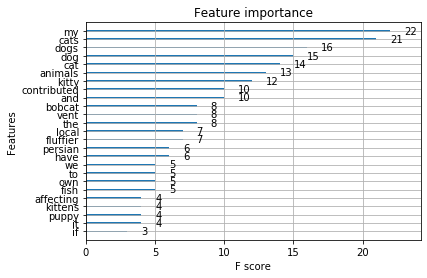

In [189]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot

# plot feature importance
clf.feature_names = vocabulary
plot_importance(clf, max_num_features = 25)
pyplot.show()

### In comments, cat/dog owners mentioned different key words, like 'kitty','persian','fish','puppy','kittens'.

### Feature 2

In [192]:
ownerData.head(3)

,creator_name,userid,labels,comment
2,bulletproof,530,0,stop saying get em youre literally dumb . have...
11,Hope For Paws - Official Rescue Channel,2911,1,That mother cat looks like my own Im guessing ...
47,Rachel Fusaro,10765,0,Im not allowed to have a dog because of money ...


In [209]:
ownerUser = ownerData[['userid', 'labels']].groupby('userid').mean().reset_index()
ownerUser.head(3)

,userid,labels
0,99,0.0
1,180,0.0
2,199,1.0


In [211]:
conditions = [
    (ownerUser['labels'] == 1) ,
    (ownerUser['labels'] == 0) ]
choices = [1, 0]
ownerUser['userLabel'] = np.select(conditions, choices, default=-1)
del ownerUser['labels']
ownerUser.head(3)

,userid,userLabel
0,99,0
1,180,0
2,199,1


In [212]:
ownerUser2 = ownerData[['userid', 'labels']].groupby('userid').size().reset_index(name='comment number')
ownerUser2.head(3)

,userid,comment number
0,99,1
1,180,1
2,199,1


In [213]:
ownerUser = ownerUser.merge(ownerUser2, left_on='userid', right_on='userid')
ownerUser.head(3)

,userid,userLabel,comment number
0,99,0,1
1,180,0,1
2,199,1,1


In [215]:
ownerUser[['userLabel', 'comment number']].groupby('userLabel').mean()

,comment number
userLabel,
-1,3.681257
0,1.152029
1,1.163760


### In average, dog owners have 1.163 comments per ID, while cat owners have 1.152 comments per ID. The users owning both dog and cat have 3.68 commnents per ID. Dog owners comment more. 

In [243]:
ownerUser3 = ownerData[['userid', 'creator_name']].copy().groupby('userid').nunique()
del ownerUser3['userid']
ownerUser3.reset_index(drop=True)
ownerUser3.head(3)

,creator_name
userid,
99,1
180,1
199,1


In [244]:
ownerUser = ownerData[['userid', 'labels']].groupby('userid').mean().reset_index()
conditions = [
    (ownerUser['labels'] == 1) ,
    (ownerUser['labels'] == 0) ]
choices = [1, 0]
ownerUser['userLabel'] = np.select(conditions, choices, default=-1)
del ownerUser['labels']
ownerUser.head(3)

,userid,userLabel
0,99,0
1,180,0
2,199,1


In [245]:
ownerUser = ownerUser.merge(ownerUser3, left_on='userid', right_on='userid')
ownerUser.head(3)

,userid,userLabel,creator_name
0,99,0,1
1,180,0,1
2,199,1,1


In [246]:
ownerUser[['userLabel', 'creator_name']].groupby('userLabel').mean()

,creator_name
userLabel,
-1,2.107183
0,1.058423
1,1.062314


### In average, dog owners leave comments for 1.062 creators, while cat owners leave comments for 1.058 creators. Dog owners watch pay attention to more creators. 

# Step 5: Identify Creators With Large Cat And Dog Ownership Audience

In [119]:
temp = data[['creator_name','userid','labels']].copy()
temp.head(3)

,creator_name,userid,labels
0,Doug The Pug,87,0
1,Doug The Pug,87,0
2,bulletproof,530,1


In [122]:
userInfo = temp.groupby(['creator_name','userid']).max()
userInfo.shape

(3176572, 1)

In [125]:
userInfo.head(10)

labels
creator_name               userid        
#CameraLord™ • Kor Capital 2608         0
                           7186         0
                           11321        0
                           14930        0
                           16640        0
                           16927        0
                           20048        0
                           20612        0
                           22052        0
                           25500        0

In [138]:
# compute distinct userid for each creator
creatorInfo = userInfo.groupby(['creator_name']).size().reset_index(name='user number')
print(creatorInfo.shape)
creatorInfo.head(10)

(3858, 2)


,creator_name,user number
0,#CameraLord™ • Kor Capital,1720
1,// L //,60
2,1-800-Flowers.com,6
3,100 Bigfoot Nights,63
4,100% Madison,223
5,100010782646907,6
6,1013,342
7,101rabbits,2996
8,10k,7
9,1234Rodeogirl,23


In [139]:
ownerInfo = userInfo[userInfo['labels'] != 0].groupby(['creator_name']).size().reset_index(name='owner number')
print(ownerInfo.shape)
ownerInfo.head(10)

(939, 2)


,creator_name,owner number
0,#CameraLord™ • Kor Capital,1
1,100 Bigfoot Nights,2
2,100% Madison,2
3,101rabbits,60
4,1BubbaMike1,6
5,2 Pitbulls,7
6,278pikelk,5
7,2CAN.TV - Ripley the Toucan!,14
8,5150TheBOB,2
9,76Highboy Reloading,11


In [145]:
result = creatorInfo.merge(ownerInfo, left_on='creator_name', right_on='creator_name')
print(result.shape)
result.head(10)

(939, 3)


,creator_name,user number,owner number
0,#CameraLord™ • Kor Capital,1720,1
1,100 Bigfoot Nights,63,2
2,100% Madison,223,2
3,101rabbits,2996,60
4,1BubbaMike1,143,6
5,2 Pitbulls,72,7
6,278pikelk,585,5
7,2CAN.TV - Ripley the Toucan!,5087,14
8,5150TheBOB,141,2
9,76Highboy Reloading,545,11


In [152]:
# filter the creators with only few users
result = result[result['user number'] >= 50]
result['owner ratio'] = result['owner number'] / result['user number']
result.head(10)

,creator_name,user number,owner number,owner ratio
706,TV BINI,108,38,0.351852
129,Calm My Dog House,99,28,0.282828
109,Brent Atwater,263,73,0.277567
575,Pawfessor,715,184,0.257343
422,Larry Krohn,598,152,0.254181
610,Rachel Fusaro,452,109,0.241150
823,Zak Georges Dog Training rEvolution,13404,3152,0.235154
232,Dog Training by Kikopup,210,48,0.228571
282,Floppycats.com,560,124,0.221429
786,V4VLuLz GAMES,55,12,0.218182


## Show the top 10 creators with the largest audience fractions for cat or dog owners

In [153]:
result = result.sort_values(by = 'owner ratio', ascending=False)
result.head(10)

,creator_name,user number,owner number,owner ratio
706,TV BINI,108,38,0.351852
129,Calm My Dog House,99,28,0.282828
109,Brent Atwater,263,73,0.277567
575,Pawfessor,715,184,0.257343
422,Larry Krohn,598,152,0.254181
610,Rachel Fusaro,452,109,0.241150
823,Zak Georges Dog Training rEvolution,13404,3152,0.235154
232,Dog Training by Kikopup,210,48,0.228571
282,Floppycats.com,560,124,0.221429
786,V4VLuLz GAMES,55,12,0.218182


In [154]:
result['creator_name'][:10]

706                                TV BINI
129                      Calm My Dog House
109                          Brent Atwater
575                              Pawfessor
422                            Larry Krohn
610                          Rachel Fusaro
823    Zak Georges Dog Training rEvolution
232                Dog Training by Kikopup
282                         Floppycats.com
786                          V4VLuLz GAMES
Name: creator_name, dtype: object